Information regarding how to set this up from scratch can be found in https://gitlab.gfdl.noaa.gov/aparna.radhakrishnan/demos/blob/master/notes  
For dask specific tutorials, here is the reference:
https://mom6-analysiscookbook.readthedocs.io/en/latest/01a_setting_up_dask_jobqueue.html

For general info on GFDL specific Python/Jupyter/Anaconda, please checkout http://wiki.gfdl.noaa.gov/Python. It also has information on port for
Data citation

Zhao, Ming; Blanton, Chris; John, Jasmin G; Radhakrishnan, Aparna; Zadeh, Niki T.; McHugh, Colleen; Rand, Kristopher; Vahlenkamp, Hans; Wilson, Chandin; Ginoux, Paul; Malyshev, Sergey; Wyman, Bruce; Guo, Huan; Balaji, V; Held, Isaac M; Dunne, John P.; Winton, Michael; Adcroft, Alistair; Milly, P.C.D; Shevliakova, Elena; Knutson, Thomas; Ploshay, Jeffrey; Zeng, Yujin (2018). NOAA-GFDL GFDL-CM4C192 model output prepared for CMIP6 HighResMIP. Version 20180701 [1].Earth System Grid Federation. https://doi.org/10.22033/ESGF/CMIP6.2262




User input: Dask analysis template

Examine the chunk size and shape 

In [1]:
import os 
clusterType = "SLURM" #or SLURM or Local
platform = "PPAN"
numCores = 6
numWorkers = 6
mem='48GB'
varname='tas'
dashPort = ':1984'
if (platform == "PPAN"):
    logdir = '/work/a1r/dask/logs/'
    localdir = '' #We will set local directory when we define the cluster
else:
    logdir = '/local2/home/a1r/logs/'
    localdir = logdir
print("Logs:", logdir)

res_nc = {} #settings, time
res_zarr = {} #settings, time

Logs: /work/a1r/dask/logs/


In [2]:
# get the plot in notebook
%matplotlib inline
import xarray as xr 

Use dask.distributed task scheduler and launch DASK using SLURMcluster

In [3]:
from dask.distributed import Client

#Instantiate Dask client
if (clusterType == "local"):
    from dask.distributed import LocalCluster
    #client = Client() or the following so we can specify dashboard port
    cluster = LocalCluster(dashboard_address=dashPort,local_directory=localdir)
else:
    from dask_jobqueue import SLURMCluster
    scheduler_options = {}
    scheduler_options["dashboard_address"] = dashPort
    cluster = SLURMCluster(queue='batch',memory=mem,project='gfdl_f',cores=numCores,walltime='2:60:00',scheduler_options=scheduler_options,log_directory=logdir,local_directory=(os.getenv('TMPDIR'))) 

cluster.scale(numWorkers)
client = Client(cluster)    
client

Client Scheduler: tcp://140.208.147.176:46676 Dashboard: http://140.208.147.176:1984/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:

import dask
dask.config.get('array.chunk-size')

'128MiB'

In [5]:
dtype='nc' #nc or zarr; TODO zipstore
datadir = '/work/a1r/enes20/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4C192/highresSST-future/r1i1p1f1/3hr/'+varname+'/gr3/v20180701/'

%time ds = xr.open_mfdataset(datadir + '*.nc', chunks={'time': 10}, combine='by_coords',parallel=True,decode_cf=False)



CPU times: user 699 ms, sys: 105 ms, total: 804 ms
Wall time: 25 s


In [6]:
ds['tas'].data

,Array,Chunk
Bytes,87.25 GB,8.29 MB
Shape,"(105192, 360, 576)","(10, 360, 576)"
Count,21042 Tasks,10520 Chunks
Type,float32,numpy.ndarray


In [7]:
%time ds2 = xr.open_mfdataset(datadir + '*.nc', chunks={'time': 240}, combine='by_coords',parallel=True,decode_cf=False)

CPU times: user 343 ms, sys: 23 ms, total: 366 ms
Wall time: 12.3 s


In [8]:
ds2['tas'].data

,Array,Chunk
Bytes,87.25 GB,199.07 MB
Shape,"(105192, 360, 576)","(240, 360, 576)"
Count,880 Tasks,439 Chunks
Type,float32,numpy.ndarray


In [9]:
temp_mean = ds[varname].mean(dim=['time'])

CPU times: user 57.6 s, sys: 3.67 s, total: 1min 1s
Wall time: 1min 47s


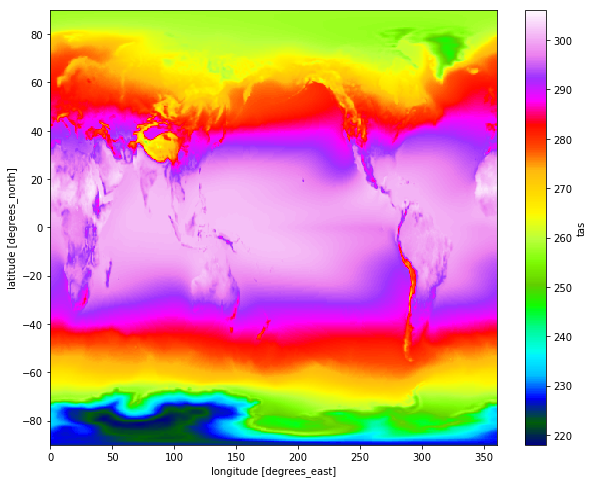

In [10]:
%time temp_mean.plot(figsize=[10, 8],cmap='gist_ncar') 

In [11]:
temp_mean2 = ds2[varname].mean(dim=['time'])

CPU times: user 4.69 s, sys: 292 ms, total: 4.98 s
Wall time: 1min


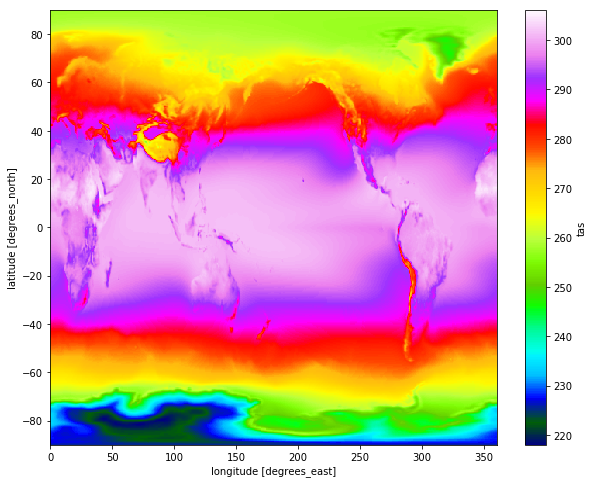

In [12]:
%time temp_mean2.plot(figsize=[10, 8],cmap='gist_ncar') 

In [13]:
cluster.close()
client.close()